In [4]:
import os
import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import Image, clear_output, display

In [5]:
# ============================================================================
# HYPERPARAMETERS
# ============================================================================

# Image settings
IMG_SIZE = 32
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)

# Model settings
LATENT_DIM = 128

# Training settings
BATCH_SIZE = 128
BUFFER_SIZE = 50000
EPOCHS = 50

# Learning Rate Berbeda untuk G dan D
LR_GEN = 2e-4
LR_DISC = 1e-4
BETA_1 = 0.5

#Label Smoothing yang Lebih Konservatif
REAL_LABEL_MIN = 0.9
REAL_LABEL_MAX = 1.0
FAKE_LABEL_MIN = 0.0
FAKE_LABEL_MAX = 0.1

# Dropout yang Lebih Ringan
DROPOUT_RATE = 0.2

# Save settings
SAVE_EVERY = 5
CHECKPOINT_EVERY = 10

# Directories
OUTPUT_DIR = Path("generated_images")
CHECKPOINT_DIR = Path("checkpoints")
LOG_DIR = Path("logs/dcgan")

# Create directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("DCGAN CIFAR-10 - Improved Training")
print("=" * 70)
print(f"Generator LR: {LR_GEN} | Discriminator LR: {LR_DISC}")
print(f"Label smoothing: Real[{REAL_LABEL_MIN}, {REAL_LABEL_MAX}] | Fake[{FAKE_LABEL_MIN}, {FAKE_LABEL_MAX}]")
print(f"Dropout: {DROPOUT_RATE}")
print("=" * 70)

DCGAN CIFAR-10 - Improved Training
Generator LR: 0.0002 | Discriminator LR: 0.0001
Label smoothing: Real[0.9, 1.0] | Fake[0.0, 0.1]
Dropout: 0.2


In [6]:
# ============================================================================
# DATA LOADING
# ============================================================================

def load_cifar10():
    """Load dan preprocess CIFAR-10"""
    print("\nLoading CIFAR-10...")
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

    # Normalize ke [-1, 1] untuk tanh activation
    x_train = x_train.astype("float32")
    x_train = (x_train / 127.5) - 1.0

    # Buat dataset
    dataset = (tf.data.Dataset.from_tensor_slices(x_train)
               .shuffle(BUFFER_SIZE)
               .batch(BATCH_SIZE, drop_remainder=True)
               .prefetch(tf.data.AUTOTUNE))

    print(f"✓ Loaded {x_train.shape[0]} images")
    return dataset

In [7]:
# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

def build_generator():
    """Generator: Latent vector -> 32x32x3 image"""
    model = tf.keras.Sequential([
        # Input: 128-dim vector
        layers.Input(shape=(LATENT_DIM,)),

        # Project & reshape: 128 -> 4x4x512
        layers.Dense(4 * 4 * 512, use_bias=False),
        layers.Reshape((4, 4, 512)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Upsample: 4x4 -> 8x8
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Upsample: 8x8 -> 16x16
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Upsample: 16x16 -> 32x32
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        # Output: 32x32x3 dengan tanh
        layers.Conv2D(CHANNELS, 3, padding='same', activation='tanh')
    ], name='generator')

    return model


def build_discriminator():
    """Discriminator: 32x32x3 image -> real/fake probability"""
    model = tf.keras.Sequential([
        # Input: 32x32x3
        layers.Input(shape=IMG_SHAPE),

        # Conv: 32x32 -> 16x16
        layers.Conv2D(64, 3, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(DROPOUT_RATE),  # PERBAIKAN 3: Dropout dikurangi

        # Conv: 16x16 -> 8x8
        layers.Conv2D(128, 3, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(DROPOUT_RATE),

        # Conv: 8x8 -> 4x4
        layers.Conv2D(256, 3, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(DROPOUT_RATE),

        # Output: single logit
        layers.Flatten(),
        layers.Dense(1)
    ], name='discriminator')

    return model

In [8]:
# ============================================================================
# TRAINING SETUP
# ============================================================================

# Build models
print("\nBuilding models...")
generator = build_generator()
discriminator = build_discriminator()

# Loss function
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# PERBAIKAN 1: Optimizers dengan learning rate berbeda
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_GEN, beta_1=BETA_1)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_DISC, beta_1=BETA_1)

# Checkpoint manager
checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer
)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, CHECKPOINT_DIR.as_posix(), max_to_keep=3
)

# TensorBoard
log_dir = LOG_DIR / time.strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(log_dir.as_posix())
print(f"✓ TensorBoard logs: {log_dir}")

# Fixed noise untuk visualisasi konsisten
fixed_noise = tf.random.normal((25, LATENT_DIM))

print("\n✓ Models ready!")
generator.summary()
print()
discriminator.summary()


Building models...
✓ TensorBoard logs: logs/dcgan/20251108-135021

✓ Models ready!


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8192)           │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,806,659 (14.52 MB)

 Trainable params: 3,804,739 (14.51 MB)

 Non-trainable params: 1,920 (7.50 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,913 (1.43 MB)

 Trainable params: 374,913 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ============================================================================
# TRAINING STEP
# ============================================================================

@tf.function
def train_step(real_images):
    """Single training step untuk D dan G"""
    batch_size = tf.shape(real_images)[0]

    # PERBAIKAN 2: Label smoothing lebih konservatif
    real_labels = tf.random.uniform(
        (batch_size, 1),
        minval=REAL_LABEL_MIN,
        maxval=REAL_LABEL_MAX
    )
    fake_labels = tf.random.uniform(
        (batch_size, 1),
        minval=FAKE_LABEL_MIN,
        maxval=FAKE_LABEL_MAX
    )

    # Generate noise
    noise = tf.random.normal((batch_size, LATENT_DIM))

    # === Train Discriminator ===
    with tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        d_loss_real = bce(real_labels, real_output)
        d_loss_fake = bce(fake_labels, fake_output)
        d_loss = d_loss_real + d_loss_fake

    d_grads = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # === Train Generator ===
    misleading_labels = tf.ones((batch_size, 1))

    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        g_loss = bce(misleading_labels, fake_output)

    g_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss

In [10]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def denormalize(images):
    """Convert [-1, 1] -> [0, 1]"""
    return (images + 1.0) / 2.0


def make_grid(images, nrow=5):
    """Buat grid dari images"""
    images = denormalize(images)
    n, h, w, c = images.shape
    ncol = (n + nrow - 1) // nrow

    grid = np.zeros((h * nrow, w * ncol, c), dtype=np.float32)

    for idx, img in enumerate(images):
        i = idx // ncol
        j = idx % ncol
        if i < nrow:
            grid[i*h:(i+1)*h, j*w:(j+1)*w] = img

    return grid


def save_and_show_images(epoch, step):
    """Generate, save, dan tampilkan images"""
    # Generate images
    images = generator(fixed_noise, training=False).numpy()
    grid = make_grid(images, nrow=5)

    # Save
    save_path = OUTPUT_DIR / f"epoch_{epoch:04d}.png"
    plt.imsave(save_path, np.clip(grid, 0, 1))

    # Display in notebook
    clear_output(wait=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid)
    plt.axis('off')
    plt.title(f'Generated Images - Epoch {epoch}', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Log to TensorBoard
    with writer.as_default():
        grid_batch = np.expand_dims(grid, 0)
        tf.summary.image("Generated", grid_batch, step=step)
    writer.flush()

In [11]:
# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def train(dataset, epochs=EPOCHS):
    """Main training loop"""
    print("\n" + "=" * 70)
    print(f"Starting training for {epochs} epochs")
    print("=" * 70 + "\n")

    global_step = 0
    history = {'epoch': [], 'd_loss': [], 'g_loss': [], 'time': []}

    for epoch in range(1, epochs + 1):
        start = time.time()

        # Metrics untuk epoch ini
        d_losses = []
        g_losses = []

        # Training loop
        for real_batch in dataset:
            d_loss, g_loss = train_step(real_batch)
            d_losses.append(float(d_loss))
            g_losses.append(float(g_loss))
            global_step += 1

            # Log ke TensorBoard setiap 100 steps
            if global_step % 100 == 0:
                with writer.as_default():
                    tf.summary.scalar("D_loss", np.mean(d_losses[-100:]), step=global_step)
                    tf.summary.scalar("G_loss", np.mean(g_losses[-100:]), step=global_step)
                writer.flush()

        # Hitung average losses
        d_loss_avg = np.mean(d_losses)
        g_loss_avg = np.mean(g_losses)
        epoch_time = time.time() - start

        # Save history
        history['epoch'].append(epoch)
        history['d_loss'].append(d_loss_avg)
        history['g_loss'].append(g_loss_avg)
        history['time'].append(epoch_time)

        # Print progress
        print(f"Epoch {epoch:3d}/{epochs} | "
              f"D_loss: {d_loss_avg:.4f} | "
              f"G_loss: {g_loss_avg:.4f} | "
              f"Time: {epoch_time:.1f}s")

        # Save images
        if epoch % SAVE_EVERY == 0 or epoch == 1:
            save_and_show_images(epoch, global_step)

        # Save checkpoint
        if epoch % CHECKPOINT_EVERY == 0:
            checkpoint_manager.save()
            print("  ✓ Checkpoint saved")

    # Final save
    checkpoint_manager.save()
    print("\n" + "=" * 70)
    print("✓ Training complete!")
    print("=" * 70)

    # Plot history
    plot_history(history)

    return history


def plot_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(history['epoch'], history['d_loss'], 'o-', label='D_loss', linewidth=2)
    axes[0].plot(history['epoch'], history['g_loss'], 's-', label='G_loss', linewidth=2)
    axes[0].axhline(y=0.693, color='r', linestyle='--', alpha=0.5, label='Target (~0.693)')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Time plot
    axes[1].plot(history['epoch'], history['time'], 'o-', color='green', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1].set_title('Training Time per Epoch', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=100, bbox_inches='tight')
    plt.show()

    # Print stats
    print("\nTraining Statistics:")
    print(f"  Average D_loss: {np.mean(history['d_loss']):.4f}")
    print(f"  Average G_loss: {np.mean(history['g_loss']):.4f}")
    print(f"  Average time/epoch: {np.mean(history['time']):.1f}s")
    print(f"  Total time: {sum(history['time'])/60:.1f} minutes")

In [12]:
# ============================================================================
# EXTRA UTILITIES
# ============================================================================

def create_gif(output_path="dcgan_cifar10.gif"):
    """Buat GIF dari hasil training"""
    pngs = sorted(OUTPUT_DIR.glob("epoch_*.png"))

    if not pngs:
        print("No images found!")
        return

    print(f"\nCreating GIF from {len(pngs)} images...")
    with imageio.get_writer(output_path, mode='I', duration=0.5) as writer:
        for png in pngs:
            writer.append_data(imageio.imread(png))

    print(f"✓ GIF saved: {output_path}")

    # Display in notebook
    try:
        display(Image(filename=output_path))
    except:
        print("Could not display GIF")


def generate_random_samples(num_samples=25):
    """Generate random samples"""
    noise = tf.random.normal((num_samples, LATENT_DIM))
    images = generator(noise, training=False).numpy()

    grid_size = int(np.ceil(np.sqrt(num_samples)))
    grid = make_grid(images, nrow=grid_size)

    plt.figure(figsize=(12, 12))
    plt.imshow(grid)
    plt.axis('off')
    plt.title(f'{num_samples} Random Samples', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()


def interpolate_images(steps=10):
    """Interpolate antara 2 random points di latent space"""
    z1 = tf.random.normal((1, LATENT_DIM))
    z2 = tf.random.normal((1, LATENT_DIM))

    alphas = np.linspace(0, 1, steps)
    latent_vectors = [z1 * (1 - a) + z2 * a for a in alphas]
    latent_vectors = tf.concat(latent_vectors, axis=0)

    images = generator(latent_vectors, training=False).numpy()

    fig, axes = plt.subplots(1, steps, figsize=(20, 3))
    for i, (ax, img) in enumerate(zip(axes, images)):
        img = denormalize(img)
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')

    plt.suptitle('Latent Space Interpolation', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

In [13]:
# ============================================================================
# QUICK START
# ============================================================================

print("\n" + "=" * 70)
print("Ready to train! Run this to start:")
print("=" * 70)
print("""
# 1. Load dataset
dataset = load_cifar10()

# 2. Train the model
history = train(dataset, epochs=50)

# 3. Create GIF
create_gif()

# 4. Generate more samples
generate_random_samples(36)
interpolate_images(10)

# 5. View TensorBoard (optional)
# %load_ext tensorboard
# %tensorboard --logdir logs/dcgan
""")
print("=" * 70)


Ready to train! Run this to start:

# 1. Load dataset
dataset = load_cifar10()

# 2. Train the model
history = train(dataset, epochs=50)

# 3. Create GIF
create_gif()

# 4. Generate more samples
generate_random_samples(36)
interpolate_images(10)

# 5. View TensorBoard (optional)
# %load_ext tensorboard
# %tensorboard --logdir logs/dcgan



In [14]:
dataset = load_cifar10()


Loading CIFAR-10...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
✓ Loaded 50000 images


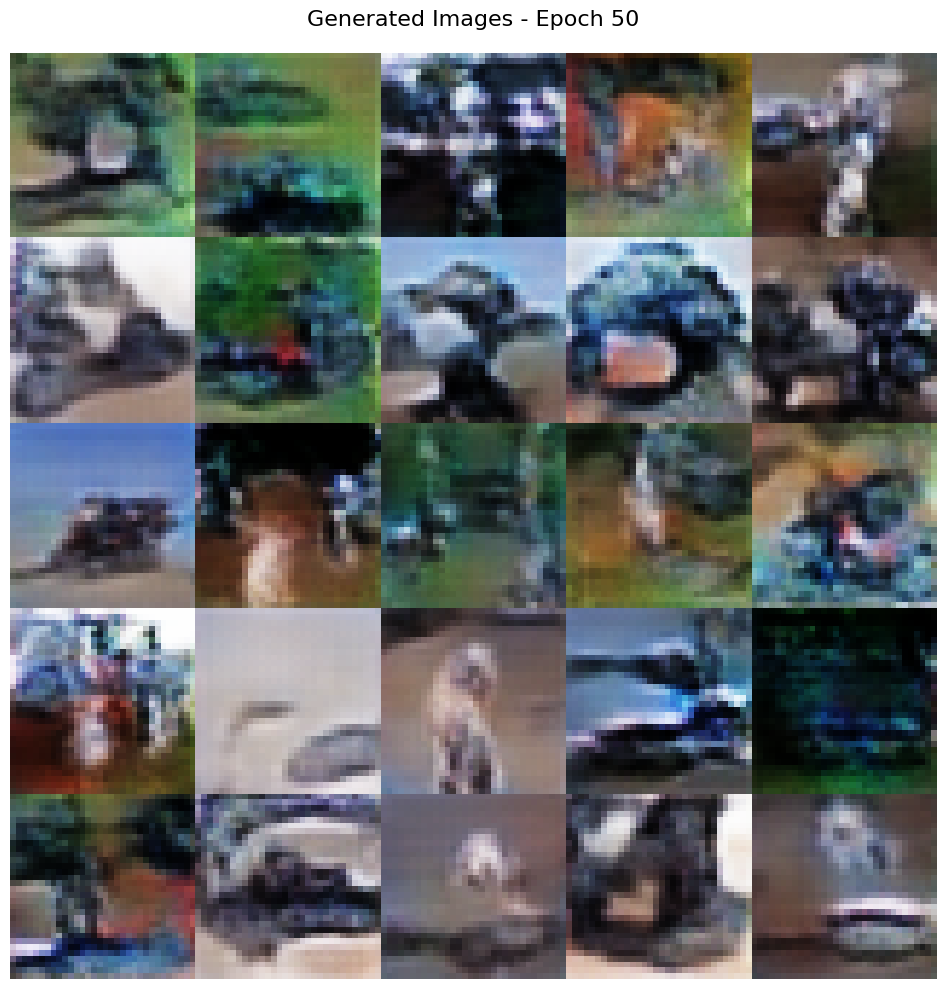

  ✓ Checkpoint saved

✓ Training complete!


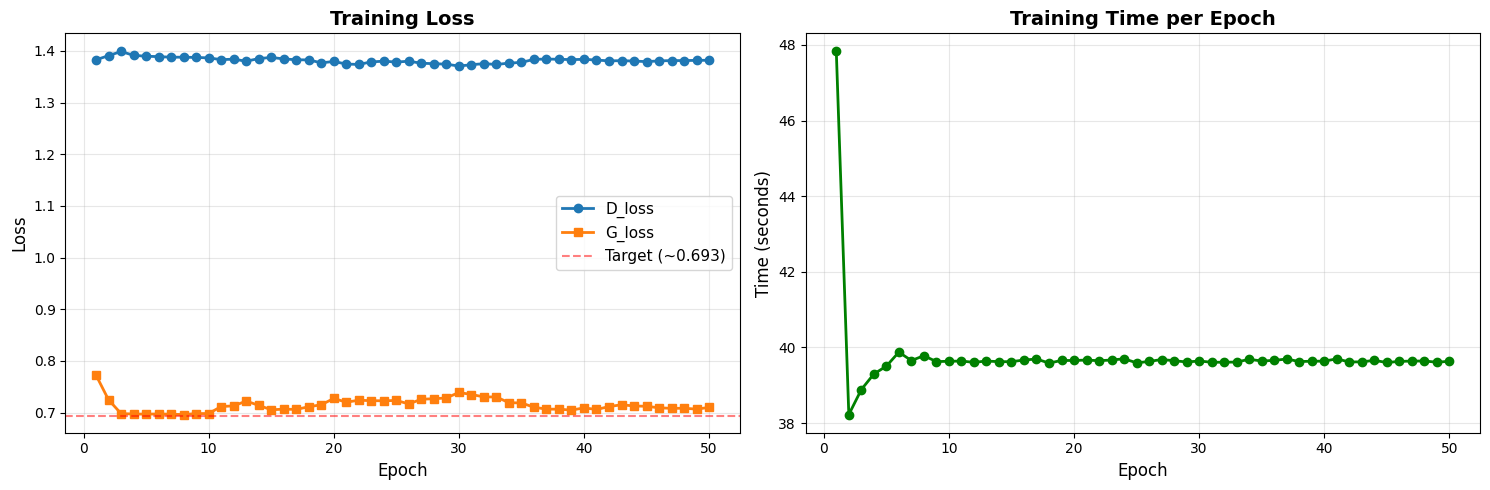


Training Statistics:
  Average D_loss: 1.3816
  Average G_loss: 0.7146
  Average time/epoch: 39.8s
  Total time: 33.1 minutes


In [15]:
history = train(dataset, epochs=50)


Creating GIF from 11 images...
✓ GIF saved: dcgan_cifar10.gif


/tmp/ipython-input-4136574649.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(png))


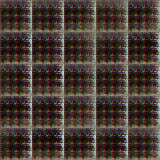

In [16]:
create_gif()

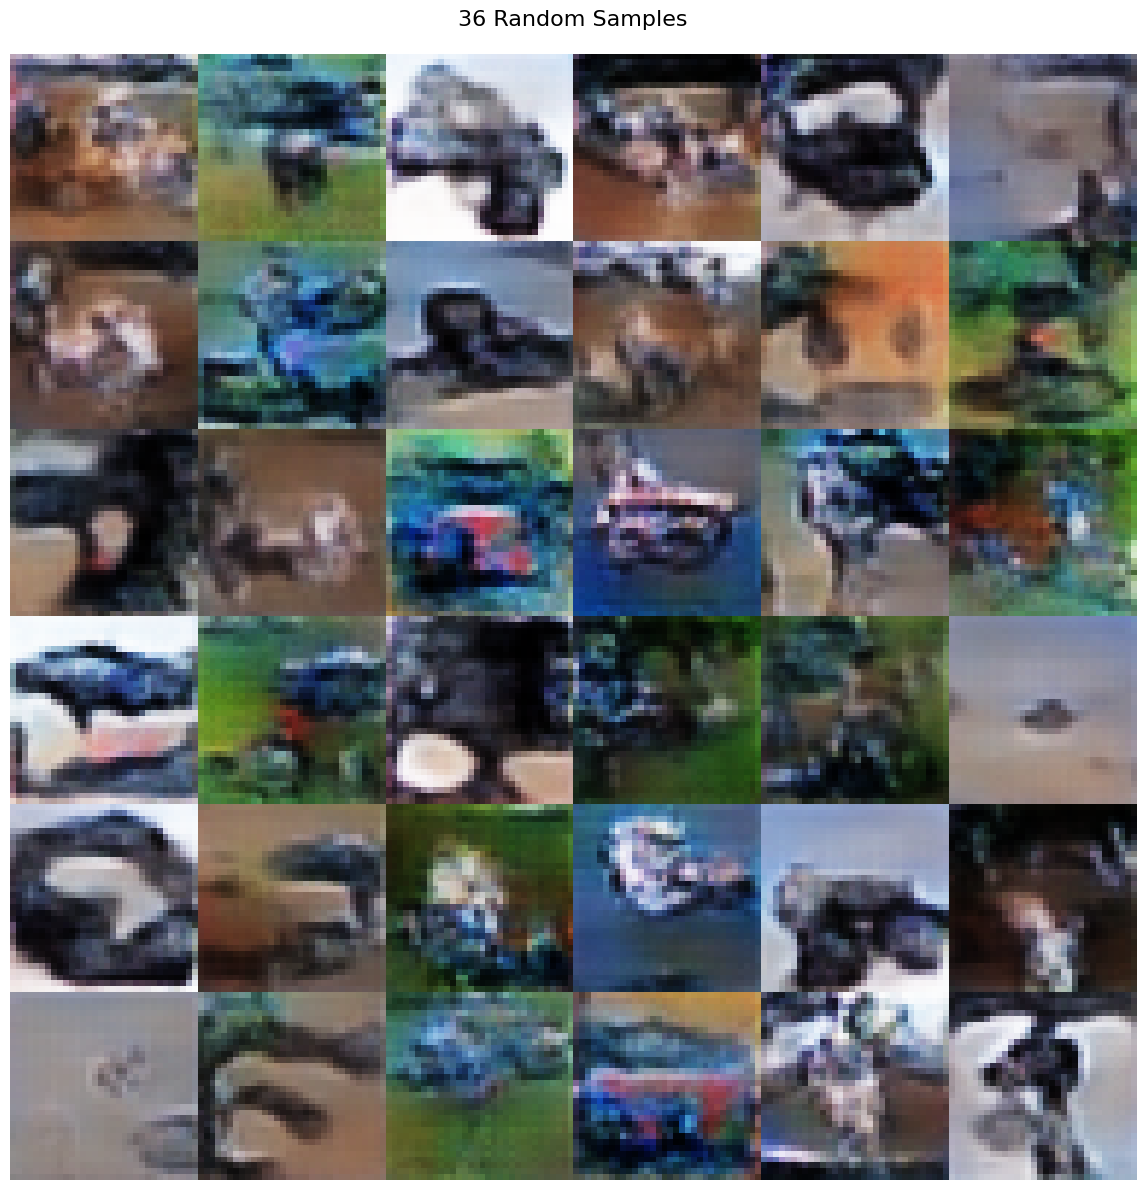

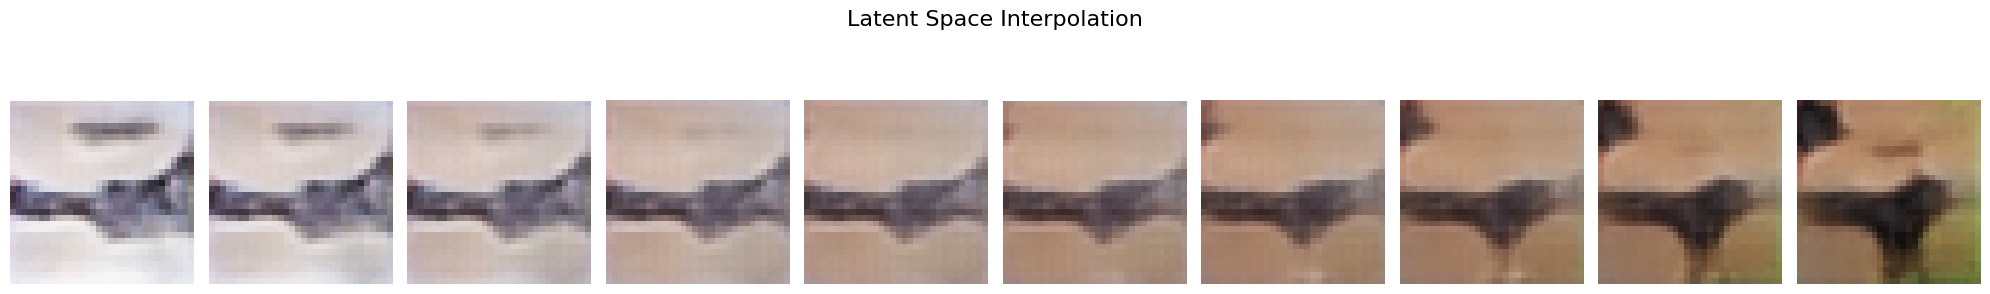

In [17]:
generate_random_samples(36)
interpolate_images(10)